In [1]:
import pandas as pd
import itertools as itt
import ppinetsim
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools as itt
import seaborn as sns

In [2]:
def to_string(x):
    return ''.join(str(x).split('.'))

def load_results(test_method, acceptance_threshold, false_positive_rate, false_negative_rate):
    infix = f'accTh{to_string(acceptance_threshold)}_FPR{to_string(false_positive_rate)}_FNR{to_string(false_negative_rate)}'
    directory = f'output_results/{test_method}/{infix}'
    posteriors = pd.read_csv(f'{directory}/likelihood_{test_method}_{infix}.csv')
    with open(f'{directory}/all_results_{test_method}_{infix}.json') as fp:
        all_results = json.load(fp)
    return posteriors, all_results

In [3]:
def deltas_sods(test_method, acceptance_threshold):
    fprs = [0.0,0.0125,0.025,0.05,0.1,0.2,0.4]
    fnrs = [0.0,0.1,0.2,0.3,0.4]
    data = {'FPR': [], 'FNR': [], 'delta_sod': []}
    for fpr, fnr in itt.product(fprs, fnrs):
        _, all_results = load_results(test_method, acceptance_threshold, fpr, fnr)
        sod_ba = 0.0
        sod_er = 0.0
        for dist, generator, _ in all_results:
            if generator == 'barabasi-albert':
                sod_ba += dist
            else:
                sod_er += dist
        data['delta_sod'].append((sod_ba - sod_er) / sod_er)
        data['FPR'].append(fpr)
        data['FNR'].append(fnr)
    return pd.DataFrame(data=data)

[Text(0.5, 1.0, 'Y2H testing, $\\gamma=0.0$')]

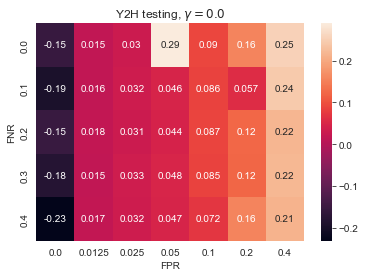

In [21]:
deltas_Y2H = deltas_sods('Y2H', 0.0)
sns.heatmap(deltas_Y2H.pivot('FNR', 'FPR', 'delta_sod'),annot=True).set(title=r'Y2H testing, $\gamma={}$'.format(0.0))

[Text(0.5, 1.0, 'AP-MS testing, $\\gamma=0.0$')]

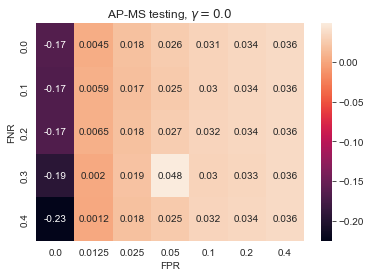

In [23]:
deltas_AP_MS = deltas_sods('AP-MS', 0.0)
sns.heatmap(deltas_AP_MS.pivot('FNR', 'FPR', 'delta_sod'),annot=True).set(title=r'AP-MS testing, $\gamma={}$'.format(0.0))

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.0$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

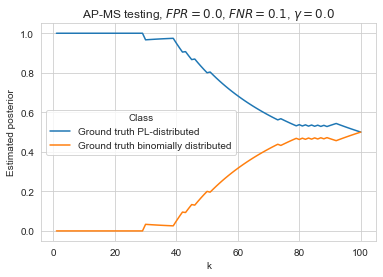

In [17]:
posteriors, all_results = load_results('AP-MS', acceptance_threshold=0.0, false_positive_rate=0.0, false_negative_rate=0.1)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.0, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, '')]

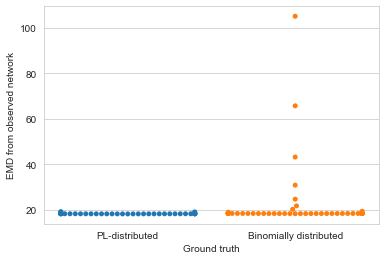

In [18]:
ppinetsim.plot_distances(all_results,kind='swarm')

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.0125$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

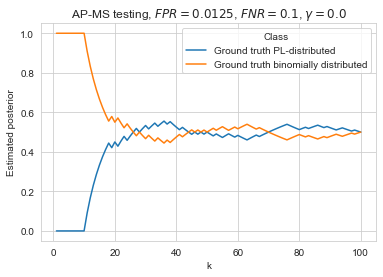

In [11]:
posteriors, all_results = load_results('AP-MS', acceptance_threshold=0.0, false_positive_rate=0.0125, false_negative_rate=0.1)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.0125, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, '')]

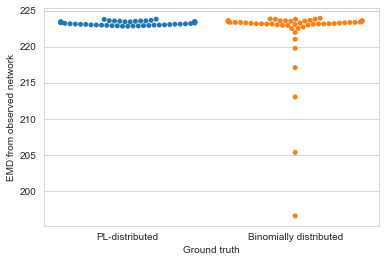

In [12]:
ppinetsim.plot_distances(all_results,kind='swarm')

[Text(0.5, 1.0, 'AP-MS testing, $\\mathit{FPR}=0.1$, $\\mathit{FNR}=0.1$, $\\gamma=0.0$')]

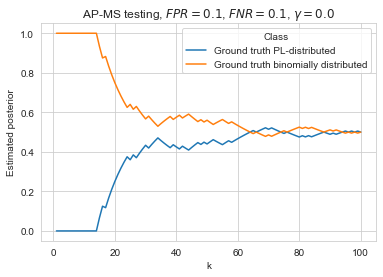

In [15]:
posteriors, all_results = load_results('AP-MS', acceptance_threshold=0.0, false_positive_rate=0.2, false_negative_rate=0.1)
ppinetsim.plot_posteriors(posteriors, parameters={'acceptance_threshold': 0.0, 'false_positive_rate': 0.1, 'false_negative_rate': 0.1, 'test_method': 'AP-MS'})

/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dbblumenthal/opt/anaconda3/envs/corrnet/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, '')]

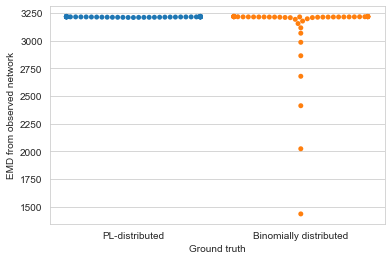

In [16]:
ppinetsim.plot_distances(all_results,kind='swarm')

[Text(0.5, 1.0, 'FPR=0.0, FNR=0.1, $\\gamma$=0.0')]

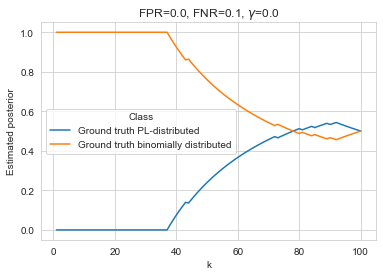

In [30]:
posteriors, _ = load_results('Y2H', acceptance_threshold=0.0, false_positive_rate=0.0, false_negative_rate=0.1)
posteriors.rename(columns={'Erdos-Renyi': 'Ground truth binomially distributed', 'Barabasi-Albert': 'Ground truth PL-distributed'}, inplace=True)
ppinetsim.plot_posteriors(posteriors, acceptance_threshold=0.0, false_positive_rate=0.0, false_negative_rate=0.1)